# IPIX Manipulation

## Imports

In [83]:
import os
import pickle
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

## CDF file exploration

In [84]:
def explore_netcdf_file(cdf_path):
    """This function shows what a single cdf file from the IPIX dataset generaly contain"""
    rootgrp = nc.Dataset(cdf_path, "r")

    print("Global attributes:")
    for attr in rootgrp.ncattrs():
        print(f"{attr}: {getattr(rootgrp, attr)}")
    
    print("\nDimensions:")
    for dim_name, dim in rootgrp.dimensions.items():
        print(f"{dim_name}: {len(dim)}")
    
    print("\nVariables:")
    for var_name, var in rootgrp.variables.items():
        print(f"Variable: {var_name}")

    print(rootgrp.variables['PRF'])
    rootgrp.close()

cdf_path = '/home/hawk/Desktop/data/IPIX/processed/cdfs/19980223_190901_ANTSTEP.CDF'
explore_netcdf_file(cdf_path)

Global attributes:
Organization: McMaster University
Instrument_name: IPIX X-band Polarimetric Coherent Radar
Campaign: Grimsby
Site: Grimsby, ON
Data_collection_date: 1998/02/23 19:09:01
TX_polarization: A
NetCDF_file_name: 19980223_190901_antstep.cdf
NetCDF_creation_routine: make_Grimsby_ncdf
NetCDF_creation_date: Mon Dec 18 21:26:02 2000
Field_CD_name: ipixcd13
Field_file_dir: Feb2398c
Field_file_name: antstep8882609417

Dimensions:
nrange: 34
nsweep: 60000
ntxpol: 2
nadc: 4

Variables:
Variable: RF_frequency
Variable: Pulse_length
Variable: PRF
Variable: Unambig_velocity
Variable: range
Variable: azimuth_angle
Variable: elevation_angle
Variable: radar_lat
Variable: radar_lon
Variable: radar_elev
Variable: antenna_beamwidth
Variable: antenna_gain
Variable: like_stc_RF
Variable: cross_stc_RF
Variable: like_stc_IF
Variable: cross_stc_IF
Variable: decimation
Variable: adc_data
<class 'netCDF4._netCDF4.Variable'>
float32 PRF()
    units: Hertz
    long_name: Radar pulse repetition frequ

In [85]:
rootgrp = nc.Dataset(cdf_path, "r")
check_it =  ncVariable_to_numpy(rootgrp.variables['PRF'])
print(rootgrp.variables['PRF'])

<class 'netCDF4._netCDF4.Variable'>
float32 PRF()
    units: Hertz
    long_name: Radar pulse repetition frequency per polarization
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used


## Convert CDF files to pickles, containing only what is needed

In [86]:
def ncVariable_to_numpy(var):
    """ This function returns valid numpy values from the cdf file"""
    value = var[:]
    mask = (value < -99999.98) & (value > 100000.00)
    value = np.ma.MaskedArray(value, mask=mask).data
    return value

def get_resolution(cdf_path):
        """ This function calculates and return the radar resolution by dividing the range by the number range bins"""
        rootgrp = nc.Dataset(cdf_path, "r")
        if 'nrange' in rootgrp.dimensions:
            nrange = len(rootgrp.dimensions['nrange'])
        
        if 'range' in rootgrp.variables:
            range_var = rootgrp.variables['range'][:]
            min_range = np.min(range_var)
            max_range = np.max(range_var)
        
        rootgrp.close()
        
        if nrange is not None and min_range is not None and max_range is not None:
            resolution = round((max_range - min_range) / nrange)
            return resolution
        else:
            return None

def ipixload(cdf_path, pol='vv', adc_like_I=None, adc_like_Q=None, adc_cross_I=None, adc_cross_Q=None):
    """ this function load """
    rootgrp = nc.Dataset(cdf_path, "r")
    rng_bins = ncVariable_to_numpy(rootgrp.variables['range'])
    adc_data = ncVariable_to_numpy(rootgrp.variables['adc_data'])

    adc_like_I = ncVariable_to_numpy(rootgrp.variables['adc_like_I']) if adc_like_I is None else adc_like_I
    adc_like_Q = ncVariable_to_numpy(rootgrp.variables['adc_like_Q']) if adc_like_Q is None else adc_like_Q
    adc_cross_I = ncVariable_to_numpy(rootgrp.variables['adc_cross_I']) if adc_cross_I is None else adc_cross_I
    adc_cross_Q = ncVariable_to_numpy(rootgrp.variables['adc_cross_Q']) if adc_cross_Q is None else adc_cross_Q
    print(adc_like_I, adc_like_Q, adc_cross_I, adc_cross_Q)

    H_txpol = 0
    V_txpol = 1
    if len(adc_data.shape) == 3:
        if pol == 'hh' or pol == 'vv':
            xiq = adc_data[:, :, [adc_like_I, adc_like_Q]]
        elif pol == 'hv' or pol == 'vh':
            xiq = adc_data[:, :, [adc_cross_I, adc_cross_Q]]
        else:
            raise Exception('Invalid polarization type')
    elif len(adc_data.shape) == 4:
        if pol == 'hh':
            xiq = adc_data[:, H_txpol, :, [adc_like_I, adc_like_Q]]
        elif pol == 'hv':
            xiq = adc_data[:, H_txpol, :, [adc_cross_I, adc_cross_Q]]
        elif pol == 'vv':
            xiq = adc_data[:, V_txpol, :, [adc_like_I, adc_like_Q]]
        elif pol == 'vh':
            xiq = adc_data[:, V_txpol, :, [adc_cross_I, adc_cross_Q]]
        else:
            raise Exception('Invalid polarization type')
    else:
        raise Exception('Invalid adc_data shape')

    xiq = np.transpose(xiq, [2, 1, 0])
    iq_mean = np.expand_dims(np.mean(xiq, 1), 1)
    iq_std = np.expand_dims(np.std(xiq, 1), 1)
    xiq = (xiq - iq_mean) / iq_std
    I = xiq[:, :, 0]
    Q = xiq[:, :, 1]
    sin_beta = np.expand_dims(np.mean(I * Q, 1), 1)
    inbal = np.arcsin(sin_beta) * 180 / np.pi
    I = (I - Q * sin_beta) / np.sqrt(1 - sin_beta ** 2)

    return I, Q, iq_mean, iq_std

def parse_ipix_data(cdf_path, pol, adc_like_I, adc_like_Q, adc_cross_I, adc_cross_Q):
    rootgrp = nc.Dataset(cdf_path, "r")

    f_c = np.expand_dims(ncVariable_to_numpy(rootgrp.variables['RF_frequency']), 0)[0] * 1e9
    PRI = 1 / np.expand_dims(ncVariable_to_numpy(rootgrp.variables['PRF']), 0)[0]
    rng_bins = ncVariable_to_numpy(rootgrp.variables['range'])
    rng_bins = np.around(rng_bins, 1)
    B = (3e8 / (2 * np.diff(rng_bins)[0]))
    I, Q, iq_mean, iq_std = ipixload(cdf_path, pol, adc_like_I, adc_like_Q, adc_cross_I, adc_cross_Q)
    iq_mean = np.squeeze(iq_mean, 1)
    iq_std = np.squeeze(iq_std, 1)
    X = np.expand_dims(iq_std[:, 0], 1) * I + 1j * np.expand_dims(iq_std[:, 1], 1) * Q

    return X, PRI, rng_bins, B

polars = ['hh', 'vv', 'hv', 'vh']
for pol in polars:
    cdf_dir = '/home/hawk/Desktop/data/IPIX/processed/cdfs'
    base_pkl_dir = '/home/hawk/Desktop/data/IPIX/processed/pkls/' + pol
    cdf_path_list = [f for f in os.listdir(cdf_dir) if not f.startswith('.')]

    for cdf_path in cdf_path_list:
        cdf_path_full = os.path.join(cdf_dir, cdf_path)
        
        resolution = get_resolution(cdf_path_full)
        
        if resolution is not None:
            X, PRI, rng_bins, B = parse_ipix_data(cdf_path_full, pol=pol, adc_like_I=2, adc_like_Q=3, adc_cross_I=0, adc_cross_Q=1)
            
            resolution_dir = os.path.join(base_pkl_dir, f'resolution_{resolution}')
            if not os.path.exists(resolution_dir):
                os.makedirs(resolution_dir)
                
            pkl_file_name = os.path.basename(cdf_path).replace(".CDF", "") + "_pol_" + pol + ".pkl"
            
            with open(os.path.join(resolution_dir, pkl_file_name), 'wb') as pkl_file:
                pickle.dump({"PRI": PRI, "rng_bins": rng_bins, "B": B, "adc_data": X}, pkl_file, protocol=3)


2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1
2 3 0 1


In [87]:
with open('/home/hawk/Desktop/data/IPIX/processed/pkls/hh/resolution_3/19980204_220046_ANTSTEP_pol_hh.pkl', 'rb') as f:
    view_saved = pickle.load(f)

In [88]:
print(view_saved.keys())
print(view_saved['PRI'])
print(view_saved['rng_bins'])
print(view_saved['B'])
print(view_saved['adc_data'].shape)

dict_keys(['PRI', 'rng_bins', 'B', 'adc_data'])
0.001
[3321. 3324. 3327. 3330. 3333. 3336. 3339. 3342. 3345. 3348. 3351. 3354.
 3357. 3360. 3363. 3366. 3369. 3372. 3375. 3378. 3381. 3384. 3387. 3390.
 3393. 3396. 3399.]
50000000.0
(27, 60000)


## Compare the different polarizations, so we dont duplicate the data

In [89]:
def compare_pickles(base_dir, resolution):
    polars = ['hh', 'vv', 'hv', 'vh']
    pkl_files = {pol: {} for pol in polars}
    
    for pol in polars:
        pol_dir = os.path.join(base_dir, pol, f'resolution_{resolution}')
        if not os.path.exists(pol_dir):
            print(f"Directory {pol_dir} does not exist.")
            return
        
        for pkl_file in os.listdir(pol_dir):
            if pkl_file.endswith('.pkl'):
                identifier = pkl_file.replace(f"_pol_{pol}.pkl", "")
                pkl_files[pol][identifier] = os.path.join(pol_dir, pkl_file)

    common_identifiers = set(pkl_files['hh'].keys())
    for pol in polars[1:]:
        common_identifiers.intersection_update(pkl_files[pol].keys())

    for identifier in common_identifiers:
        pkl_file_hh = pkl_files['hh'][identifier]
        pkl_file_vv = pkl_files['vv'][identifier]
        pkl_file_hv = pkl_files['hv'][identifier]
        pkl_file_vh = pkl_files['vh'][identifier]

        with open(pkl_file_hh, 'rb') as f:
            data_hh = pickle.load(f)
        with open(pkl_file_vv, 'rb') as f:
            data_vv = pickle.load(f)
        with open(pkl_file_hv, 'rb') as f:
            data_hv = pickle.load(f)
        with open(pkl_file_vh, 'rb') as f:
            data_vh = pickle.load(f)

        same_hh_vv = np.array_equal(data_hh['adc_data'], data_vv['adc_data'])
        same_hh_hv = np.array_equal(data_hh['adc_data'], data_hv['adc_data'])
        same_hh_vh = np.array_equal(data_hh['adc_data'], data_vh['adc_data'])
        same_vv_hv = np.array_equal(data_vv['adc_data'], data_hv['adc_data'])
        same_vv_vh = np.array_equal(data_vv['adc_data'], data_vh['adc_data'])
        same_hv_vh = np.array_equal(data_hv['adc_data'], data_vh['adc_data'])

        print(f"Comparing {pkl_file_hh}, {pkl_file_vv}, {pkl_file_hv}, {pkl_file_vh}:")
        print(f"HH == VV: {same_hh_vv}")
        print(f"HH == HV: {same_hh_hv}")
        print(f"HH == VH: {same_hh_vh}")
        print(f"VV == HV: {same_vv_hv}")
        print(f"VV == VH: {same_vv_vh}")
        print(f"HV == VH: {same_hv_vh}")
        print()

base_dir = '/home/hawk/Desktop/data/IPIX/processed/pkls'
resolution = 3  # Example resolution, replace with the actual resolution you want to compare
compare_pickles(base_dir, resolution)


Comparing /home/hawk/Desktop/data/IPIX/processed/pkls/hh/resolution_3/19980223_191339_ANTSTEP_pol_hh.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/vv/resolution_3/19980223_191339_ANTSTEP_pol_vv.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/hv/resolution_3/19980223_191339_ANTSTEP_pol_hv.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/vh/resolution_3/19980223_191339_ANTSTEP_pol_vh.pkl:
HH == VV: False
HH == HV: False
HH == VH: False
VV == HV: False
VV == VH: False
HV == VH: False

Comparing /home/hawk/Desktop/data/IPIX/processed/pkls/hh/resolution_3/19980223_171533_ANTSTEP_pol_hh.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/vv/resolution_3/19980223_171533_ANTSTEP_pol_vv.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/hv/resolution_3/19980223_171533_ANTSTEP_pol_hv.pkl, /home/hawk/Desktop/data/IPIX/processed/pkls/vh/resolution_3/19980223_171533_ANTSTEP_pol_vh.pkl:
HH == VV: False
HH == HV: False
HH == VH: False
VV == HV: False
VV == VH: False
HV == VH: False

Comparing /home/ha

## Convert IQ data to range-Doppler maps

In [90]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def range_doppler_transform(adc_data):
    # Perform FFT along range and Doppler dimensions
    rd_map = np.fft.fft2(adc_data)
    rd_map = np.fft.fftshift(rd_map)
    rd_map = 20 * np.log10(np.abs(rd_map))
    return rd_map

def save_range_doppler_map(output_path, rd_map):
    with open(output_path, 'wb') as file:
        pickle.dump(rd_map, file, protocol=3)

def create_directory_structure(base_output_dir, polars, resolutions):
    for pol in polars:
        for res in resolutions:
            dir_path = os.path.join(base_output_dir, pol, res)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

def process_all_pickles(input_dir, output_dir, polars):
    for pol in polars:
        base_pkl_dir = os.path.join(input_dir, pol)
        resolution_dirs = [d for d in os.listdir(base_pkl_dir) if os.path.isdir(os.path.join(base_pkl_dir, d))]

        for res_dir in resolution_dirs:
            full_res_dir = os.path.join(base_pkl_dir, res_dir)
            pkl_files = [f for f in os.listdir(full_res_dir) if f.endswith('.pkl')]

            for pkl_file in pkl_files:
                pkl_path = os.path.join(full_res_dir, pkl_file)
                data = load_pickle_file(pkl_path)
                
                adc_data = data['adc_data']
                rd_map = range_doppler_transform(adc_data)
                
                # Save the range-Doppler map
                output_res_dir = os.path.join(output_dir, pol, res_dir)
                output_file_path = os.path.join(output_res_dir, pkl_file)
                save_range_doppler_map(output_file_path, rd_map)
                
                #print(f"Processed and saved range-Doppler map for {pkl_file}")
            print(f"finished conversion for {pol} polarization")

# Define input and output directories and polarizations
input_dir = '/home/hawk/Desktop/data/IPIX/processed/pkls'
output_dir = '/home/hawk/Desktop/data/IPIX/processed/rds'
polars = ['hh', 'vv', 'hv', 'vh']
resolutions = ['resolution_3', 'resolution_9', 'resolution_14', 'resolution_15', 'resolution_29', 'resolution_58']

# Create the directory structure for the output
create_directory_structure(output_dir, polars, resolutions)

# Process all pickle files and generate range-Doppler maps
process_all_pickles(input_dir, output_dir, polars)


finished conversion for hh polarization
finished conversion for hh polarization
finished conversion for hh polarization
finished conversion for hh polarization
finished conversion for hh polarization
finished conversion for hh polarization
finished conversion for vv polarization
finished conversion for vv polarization
finished conversion for vv polarization
finished conversion for vv polarization
finished conversion for vv polarization
finished conversion for vv polarization
finished conversion for hv polarization
finished conversion for hv polarization
finished conversion for hv polarization
finished conversion for hv polarization
finished conversion for hv polarization
finished conversion for hv polarization
finished conversion for vh polarization
finished conversion for vh polarization
finished conversion for vh polarization
finished conversion for vh polarization
finished conversion for vh polarization
finished conversion for vh polarization


In [91]:
def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def apply_window(adc_data, window_type='hann'):
    # Apply window function to the ADC data along both range and Doppler dimensions
    if window_type == 'hann':
        window = np.hanning(adc_data.shape[0])[:, None] * np.hanning(adc_data.shape[1])[None, :]
    else:
        raise ValueError('Unsupported window type')
    return adc_data * window

def range_doppler_transform(adc_data, window_type='hann'):
    # Apply window function
    adc_data_windowed = apply_window(adc_data, window_type)

    # Perform FFT along range and Doppler dimensions
    rd_map = np.fft.fft2(adc_data_windowed)
    rd_map = np.fft.fftshift(rd_map)
    rd_map = 20 * np.log10(np.abs(rd_map) + 1e-6)  # Avoid log(0) issues
    return rd_map

def save_range_doppler_map(output_path, rd_map):
    with open(output_path, 'wb') as file:
        pickle.dump(rd_map, file, protocol=3)

def create_directory_structure(base_output_dir, polars, resolutions):
    for pol in polars:
        for res in resolutions:
            dir_path = os.path.join(base_output_dir, pol, res)
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

def process_all_pickles(input_dir, output_dir, polars, window_type='hann'):
    for pol in polars:
        base_pkl_dir = os.path.join(input_dir, pol)
        resolution_dirs = [d for d in os.listdir(base_pkl_dir) if os.path.isdir(os.path.join(base_pkl_dir, d))]

        for res_dir in resolution_dirs:
            full_res_dir = os.path.join(base_pkl_dir, res_dir)
            pkl_files = [f for f in os.listdir(full_res_dir) if f.endswith('.pkl')]

            for pkl_file in pkl_files:
                pkl_path = os.path.join(full_res_dir, pkl_file)
                data = load_pickle_file(pkl_path)
                
                adc_data = data['adc_data']
                rd_map = range_doppler_transform(adc_data, window_type)
                
                # Save the range-Doppler map
                output_res_dir = os.path.join(output_dir, pol, res_dir)
                output_file_path = os.path.join(output_res_dir, pkl_file)
                save_range_doppler_map(output_file_path, rd_map)
                
                #print(f"Processed and saved range-Doppler map for {pkl_file}")
            print(f"Finished conversion for {pol} polarization")

# Define input and output directories and polarizations
input_dir = '/home/hawk/Desktop/data/IPIX/processed/pkls'
output_dir = '/home/hawk/Desktop/data/IPIX/processed/rds'
polars = ['hh', 'vv', 'hv', 'vh']
resolutions = ['resolution_3', 'resolution_9', 'resolution_14', 'resolution_15', 'resolution_29', 'resolution_58']

# Create the directory structure for the output
create_directory_structure(output_dir, polars, resolutions)

# Process all pickle files and generate range-Doppler maps
process_all_pickles(input_dir, output_dir, polars)



Finished conversion for hh polarization
Finished conversion for hh polarization
Finished conversion for hh polarization
Finished conversion for hh polarization
Finished conversion for hh polarization
Finished conversion for hh polarization
Finished conversion for vv polarization
Finished conversion for vv polarization
Finished conversion for vv polarization
Finished conversion for vv polarization
Finished conversion for vv polarization
Finished conversion for vv polarization
Finished conversion for hv polarization
Finished conversion for hv polarization
Finished conversion for hv polarization
Finished conversion for hv polarization
Finished conversion for hv polarization
Finished conversion for hv polarization
Finished conversion for vh polarization
Finished conversion for vh polarization
Finished conversion for vh polarization
Finished conversion for vh polarization
Finished conversion for vh polarization
Finished conversion for vh polarization


In [92]:
example_pkl_file = '/home/hawk/Desktop/data/IPIX/processed/rds/hh/resolution_3/19980223_205830_ANTSTEP_pol_hh.pkl'
with open(example_pkl_file,'rb') as f:
    example = pickle.load(f)

In [93]:
example.shape

(34, 60000)

## View range doppler maps

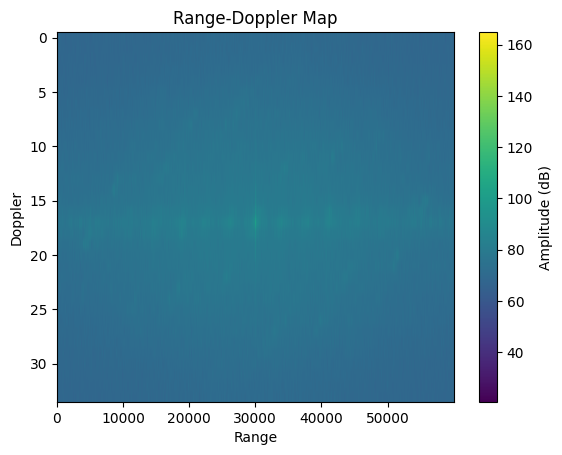

In [94]:
def load_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def range_doppler_transform(adc_data):
    # Perform FFT along range and Doppler dimensions
    rd_map = np.fft.fft2(adc_data)
    rd_map = np.fft.fftshift(rd_map)
    rd_map = 20 * np.log10(np.abs(rd_map))
    return rd_map

def save_range_doppler_map(output_path, rd_map):
    with open(output_path, 'wb') as file:
        pickle.dump(rd_map, file, protocol=3)

def visualize_range_doppler_map(rd_map):
    plt.imshow(rd_map, aspect='auto')#, cmap='viridis')
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('Range')
    plt.ylabel('Doppler')
    plt.title('Range-Doppler Map')
    plt.show()

# Example visualization
example_pkl_file = '/home/hawk/Desktop/data/IPIX/processed/rds/hh/resolution_3/19980223_205830_ANTSTEP_pol_hh.pkl'
data = load_pickle_file(example_pkl_file)

# Debug: print the type and shape of adc_data
#print(f"Type of adc_data: {type(data['adc_data'])}")
#print(f"Shape of adc_data: {data['adc_data'].shape}")

# Perform range-Doppler transform and visualize
rd_map = range_doppler_transform(data)
visualize_range_doppler_map(rd_map)


In [95]:
example_rd_file = '/home/hawk/Desktop/data/IPIX/processed/rds/hh/resolution_3/19980204_220046_ANTSTEP_pol_hh.pkl'
example_iq_file = '/home/hawk/Desktop/data/IPIX/processed/pkls/hh/resolution_3/19980204_220046_ANTSTEP_pol_hh.pkl'
rd_example = load_pickle_file(example_rd_file)
IQ_example = load_pickle_file(example_iq_file)

In [96]:
print(len(rd_example))
print(len(rd_example[0]))

27
60000


In [97]:
print(len(IQ_example['adc_data']))
print(len(IQ_example['adc_data'][0]))

27
60000
